In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import nltk
from bs4 import BeautifulSoup

from utils.utils import *
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [5]:
df = pd.read_csv('QueryResults(1).csv')
df.head()

,post_id,parent_id,Title,post_text,com_id,com_text,com_user_id,reputation,dt
0,68831096,NaN,Why can't std::stringstream be default constru...,<p>The following compiles fine (on g++ 8.3.0-6...,121644544,works fine with newer version https://godbolt....,4117728,81863,2021-08-18 10:59:42
1,68831096,NaN,Why can't std::stringstream be default constru...,<p>The following compiles fine (on g++ 8.3.0-6...,121644785,Seems to be the same question: [Why GCC doesn'...,7976805,14493,2021-08-18 10:59:42
2,68831096,NaN,Why can't std::stringstream be default constru...,<p>The following compiles fine (on g++ 8.3.0-6...,121644610,"Looks like compiler bug, it works with GCC 9.1",7976805,14493,2021-08-18 10:59:42
3,68831099,NaN,Transform an Array in JavaScript,<p>I have a simple problem that I can't solve...,121644586,"there should be examples of how to do this, it...",301774,6388,2021-08-18 10:59:46
4,68831099,NaN,Transform an Array in JavaScript,<p>I have a simple problem that I can't solve...,121644602,https://stackoverflow.com/questions/37075180/c...,301774,6388,2021-08-18 10:59:46


In [25]:
post_text = [BeautifulSoup(s, 'html.parser').text for s in list(set(df['post_text'].fillna('')))]
com_text = list(set(df['com_text'].fillna('')))
title_text = list(set(df['Title'].fillna('')))
text = post_text + com_text + title_text

In [34]:
 # для интереса найдем распределение длины каждого из вида текста: Title, post_text, com_text
lens = []
for sentence in text:
    lens.append(len(sentence))

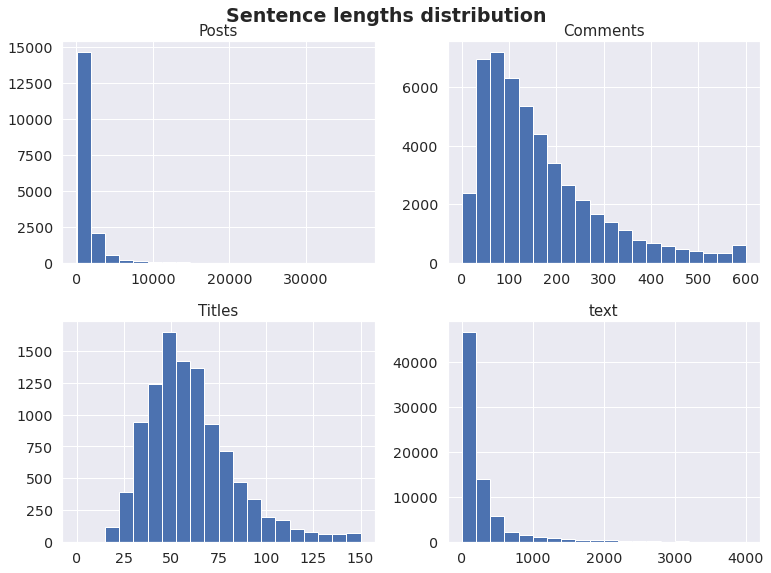

In [35]:
sns.set(font_scale=1.3)
plt.figure(figsize=(11, 8))
plt.suptitle('Sentence lengths distribution', y=1, fontsize=19, fontweight='bold')

plt.subplot(2, 2, 1)
plt.title('Posts', fontsize=15)
plt.hist(lens[:len(post_text)+1], bins=20)

plt.subplot(2, 2, 2)
plt.title('Comments', fontsize=15)
plt.hist(lens[len(post_text):len(post_text)+len(com_text)+1], bins=20)

plt.subplot(2, 2, 3)
plt.title('Titles', fontsize=15)
plt.hist(lens[len(post_text)+len(com_text):], bins=20)

plt.subplot(2, 2, 4)
plt.title('text', fontsize=15)
plt.hist(lens, bins=20, range = (0, 4000))

plt.tight_layout()

In [27]:
%%time
stop_words = stopwords.words('english')
cv = CountVectorizer(stop_words = stop_words, max_features = 1500, preprocessor = my_cool_preprocessor)
count_vector=cv.fit_transform(text).toarray()

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  % sorted(inconsistent)


CPU times: user 27.4 s, sys: 622 ms, total: 28.1 s
Wall time: 28.2 s


In [28]:
%%time
names = cv.get_feature_names()
count = [np.sum(count_vector[:,i]) for i in range(count_vector.shape[1])]
ls = list(zip(names, count))
dc = sort_dict(dict(zip(names, count)))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


CPU times: user 2.04 s, sys: 7.7 ms, total: 2.04 s
Wall time: 2.05 s


Исключим фразы с некоторыми словами, которые используются только для написания кода. Есть и другие "вредные" слова, но определить их всех довольно тяжело

In [30]:
 # Исключим слова, 
 # которые используются только при написания кода
words = ['http', 'int', 'float', 'com', 'nan', 'html', 'href']
chk_pat = '(?:{})'.format('|'.join(words))
dc = {k:v for k, v in dc.items() if not bool(re.search(chk_pat, k, flags=re.I))}

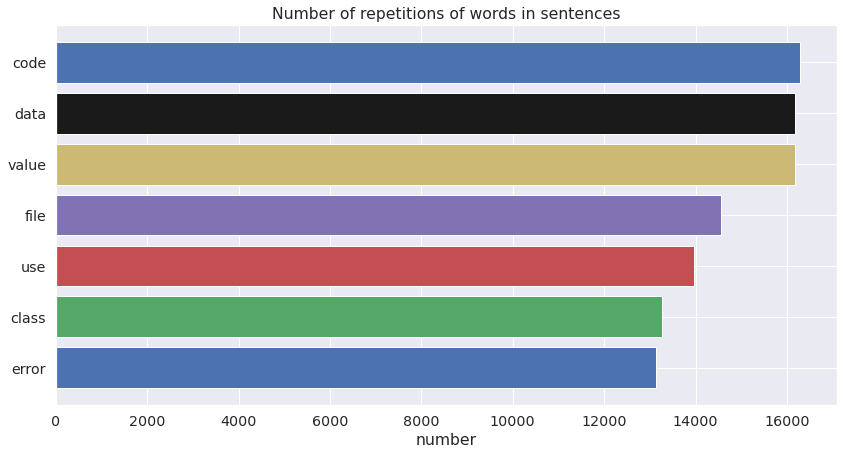

In [31]:
plt.figure(figsize=(14, 7))
plt.subplots_adjust(hspace=0.5)

plt.title('Number of repetitions of words in sentences')
plt.barh(list(dc.keys())[:7][::-1], list(dc.values())[:7][::-1], color=['b', 'g', 'r', 'm', 'y', 'k'])
plt.xlabel('number')

plt.show()

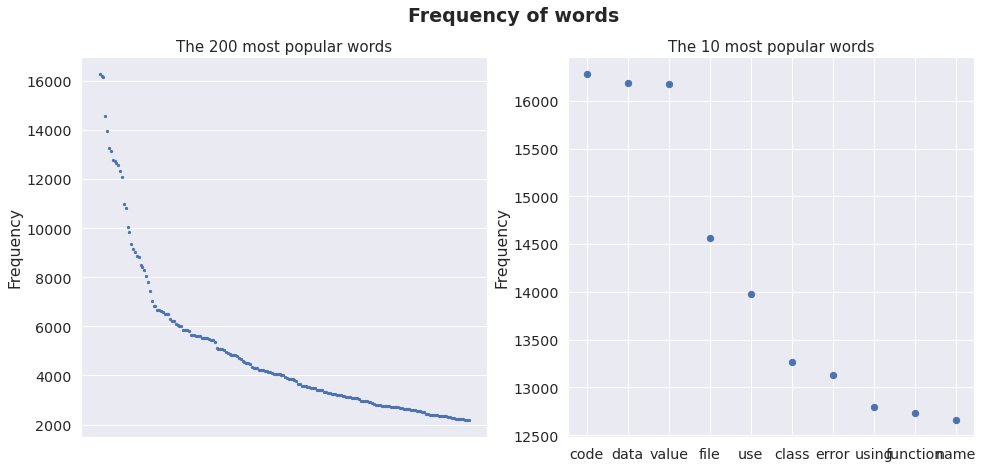

In [32]:
plot_history(dc, a = 200, b = 10, xtitle = True)

In [ ]:
 # сохраним в файл csv
history_path_to_save='./words.csv'
pd.DataFrame(list(dc.items())).to_csv(history_path_to_save, index = False)

# Выводы

Заметим, что частотный анализ слов в тексте прошел положительно

Нерешенные проблемы:

1) Не понятно, как выделить текст сообщения, без участков кода. Исходные предложения содержат в себе теги HTML. В общем случае непонятно, какой тег за что отвечает и нужно ли убирать текст между ними. Из-за этого и возникает проблема с такими словами, как "http", "html" и т.д.

2) Удаление стоп-слов. Исходно не известно на каком языке посты, поэтому непонятно, какие стоп слова брать. Судя по исходным данным, весь текст на английском, поэтому я брал английские стоп-слова

Можно сделать вывод, что такой способ частотного анализа можно использовать на практике